## This notebook will run and analyse the Model for the Subway Data


## Random forest model training

In [4]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
##Writing installed packages to requirements.txt file
!pip freeze > subway_requirements.txt

In [6]:
#import the csv file needed to train the model
df=pd.read_csv('cleaned_busyness_data.csv')
df.head(10)

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,weather,rain_fall,snow_fall
0,R001,1546300800,0,0,61,12,0,Tuesday,January,3.42,Rain,3.06,4.40
1,R001,1546315200,102,104,61,18,4,Tuesday,January,5.89,Rain,3.77,2.21
2,R001,1546329600,96,51,55,16,8,Tuesday,January,11.18,Mist,0.00,0.12
3,R001,1546344000,260,476,82,42,12,Tuesday,January,13.55,Rain,0.25,0.06
4,R001,1546358400,540,496,55,58,16,Tuesday,January,11.68,Rain,0.50,0.25
5,R001,1546372800,602,250,0,48,20,Tuesday,January,3.70,Clouds,0.00,0.05
6,R001,1546387200,159,147,59,22,0,Wednesday,January,2.05,Clouds,0.00,0.00
7,R001,1546401600,48,38,59,14,4,Wednesday,January,-0.06,Clouds,0.00,0.00
8,R001,1546416000,516,434,51,54,8,Wednesday,January,-2.08,Clear,0.00,0.00
9,R001,1546430400,842,1351,96,96,12,Wednesday,January,-1.89,Clear,0.00,0.00


In [7]:
#convert monthand day to numerical columns
df['month']=df['month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
df['day']=df['day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})


In [8]:
#convert weather to categorical columns
df['weather']=df['weather'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297835 entries, 0 to 297834
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   remote_unit_id             297835 non-null  object  
 1   time_stamp                 297835 non-null  int64   
 2   entries                    297835 non-null  int64   
 3   exits                      297835 non-null  int64   
 4   surrounding_area_busyness  297835 non-null  int64   
 5   station_busyness           297835 non-null  int64   
 6   hour                       297835 non-null  int64   
 7   day                        297835 non-null  int64   
 8   month                      297835 non-null  int64   
 9   temperature                297835 non-null  float64 
 10  weather                    297835 non-null  category
 11  rain_fall                  297835 non-null  float64 
 12  snow_fall                  297835 non-null  float64 
dtypes: category(1)

### Create a correlation matrix to see strength of correlations between feature pairs

/tmp/ipykernel_21689/2506163149.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat=df.corr()


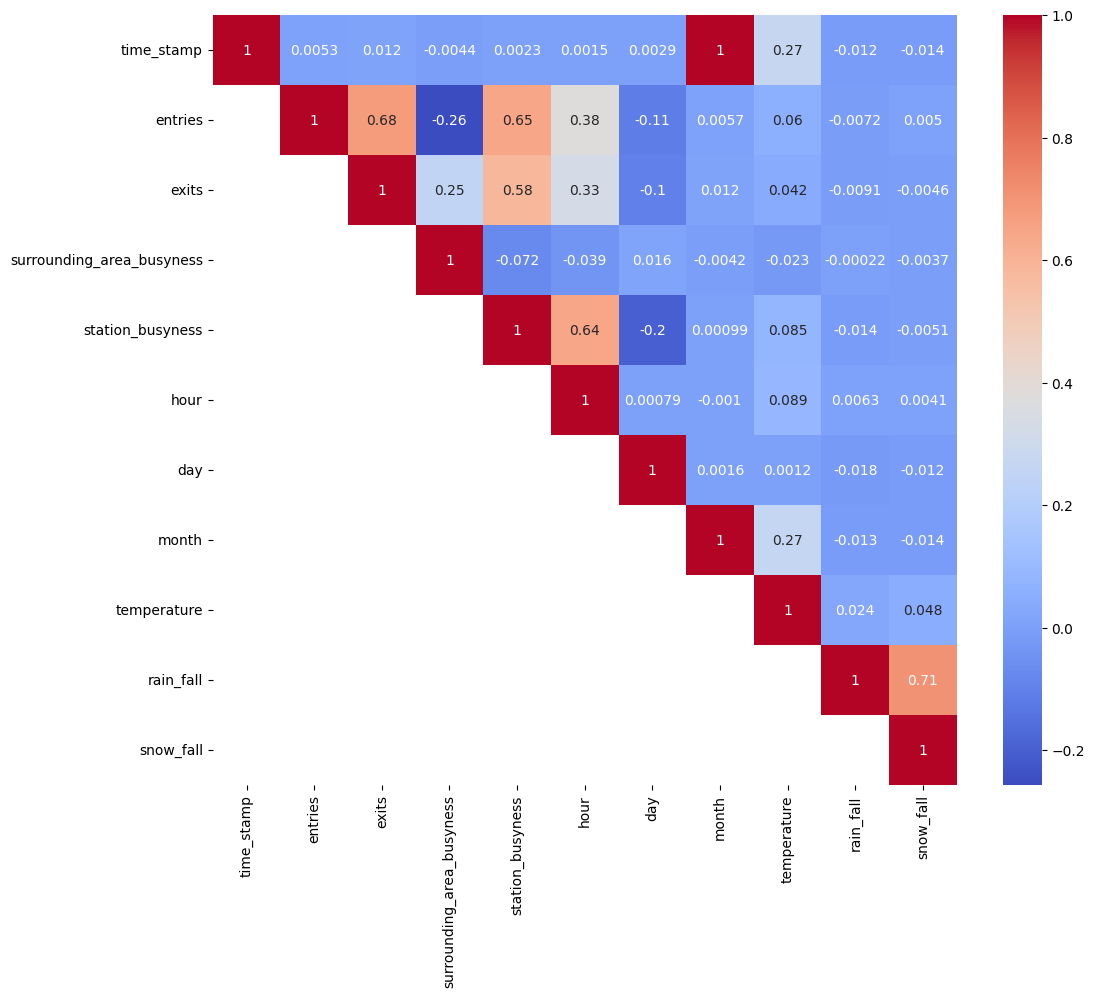

In [10]:
mat=df.corr()

# create a mask to drop the upper triangle
mask = np.triu(np.ones_like(mat, dtype=bool))

# apply the mask to the correlation matrix
mat = mat.where(mask)

fig, ax = plt.subplots(figsize=(12, 10))

sea.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)

# show the plot
plt.show()

In [11]:
df.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits',
       'surrounding_area_busyness', 'station_busyness', 'hour', 'day', 'month',
       'temperature', 'weather', 'rain_fall', 'snow_fall'],
      dtype='object')

## One hot encoding for categorical features


In [12]:
one_hot = pd.get_dummies(df['weather'])
df = pd.concat([df, one_hot], axis = 1)

In [13]:
df.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
0,R001,1546300800,0,0,61,12,0,2,1,3.42,...,0,0,0,0,0,0,1,0,0,0
1,R001,1546315200,102,104,61,18,4,2,1,5.89,...,0,0,0,0,0,0,1,0,0,0
2,R001,1546329600,96,51,55,16,8,2,1,11.18,...,0,0,0,0,0,1,0,0,0,0
3,R001,1546344000,260,476,82,42,12,2,1,13.55,...,0,0,0,0,0,0,1,0,0,0
4,R001,1546358400,540,496,55,58,16,2,1,11.68,...,0,0,0,0,0,0,1,0,0,0


## Functions to train the models

In [14]:

def divide_data_surrounding_area_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['surrounding_area_busyness'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['surrounding_area_busyness','station_busyness','remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months? 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test


def divide_data_station_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['station_busyness'].values
    #drop these values for query search
    #why drop remote unit id- because it is just used to identify which model we need
    df_inner=df_inner.drop(columns=['surrounding_area_busyness','station_busyness', 'remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test

test_mae_list = []
test_rmse_list = []
test_mape_list=[]
test_rrmse_list=[]
test_score_list = []

def forest_training_model(train_x, train_y, test_x, test_y):
    #expirement with different parameters here
    forest = RandomForestClassifier(n_estimators=80, max_depth=10)
    forest = forest.fit(train_x, train_y)

    test_predictions = forest.predict(test_x)

    test_mae = mean_absolute_error(test_y, test_predictions)
    test_mae_list.append(test_mae)

    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    test_rmse_list.append(test_rmse)
    
    test_mape = calculate_mape(test_y, test_predictions)
    test_mape_list.append(test_mape)

    test_rrmse = test_rmse / np.mean(test_y)
    test_rrmse_list.append(test_rrmse)

    test_r2 = r2_score(test_y, test_predictions)
    test_score_list.append(test_r2)

    return forest


def calculate_mape(actual, predicted):
    # Calculate MAPE while handling zero values in actual
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1, actual))) * 100
    return mape

## Description of the error metrics:

### Mean Absolute Error:

### Mean Squared Error:

### Mean Absolute Percentage Error:

### R2 Score: same?

### Root Mean Squared Error:

### Include others????

## Function to save the models

In [15]:
def save_model_station_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

def save_model_area_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/area_busy/a_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

### Clean the pickle dataframe 
- In order to reduce the size and time taken to run the models


In [16]:
df.drop(columns=['weather'], inplace=True)
df_pickle=df.copy()


In [17]:
df_pickle.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits',
       'surrounding_area_busyness', 'station_busyness', 'hour', 'day', 'month',
       'temperature', 'rain_fall', 'snow_fall', 'Clear', 'Clouds', 'Drizzle',
       'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Thunderstorm'],
      dtype='object')

In [18]:
#drop entries exits and timestamp from the pickle model, we wont know these to give to it, 
#and for each pickle one it cant have the other perctenage busyness

df_pickle.drop(columns=['time_stamp', 'entries', 'exits'],axis=1,inplace=True)


In [19]:
df_pickle.columns

Index(['remote_unit_id', 'surrounding_area_busyness', 'station_busyness',
       'hour', 'day', 'month', 'temperature', 'rain_fall', 'snow_fall',
       'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke',
       'Snow', 'Thunderstorm'],
      dtype='object')

In [20]:
df_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297835 entries, 0 to 297834
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   remote_unit_id             297835 non-null  object 
 1   surrounding_area_busyness  297835 non-null  int64  
 2   station_busyness           297835 non-null  int64  
 3   hour                       297835 non-null  int64  
 4   day                        297835 non-null  int64  
 5   month                      297835 non-null  int64  
 6   temperature                297835 non-null  float64
 7   rain_fall                  297835 non-null  float64
 8   snow_fall                  297835 non-null  float64
 9   Clear                      297835 non-null  uint8  
 10  Clouds                     297835 non-null  uint8  
 11  Drizzle                    297835 non-null  uint8  
 12  Fog                        297835 non-null  uint8  
 13  Haze                       29

In [21]:
#count the occurances of 1 in the following columns: Clear, Clouds, Drizzle, Fog etc
occurrences = df[['Clear', 'Clouds', 'Drizzle', 'Fog','Haze', 'Mist','Rain','Smoke','Snow','Thunderstorm']].sum(axis=0)
occurrences


Clear           138538
Clouds           78392
Drizzle           2450
Fog               2131
Haze              2695
Mist             18158
Rain             49849
Smoke              568
Snow              4073
Thunderstorm       981
dtype: int64

## Execute the models

### Get station numbers

In [22]:
df_static = pd.read_csv('cleaned_station_data.csv')
check=df_static["remote_unit_id"]
order=check.tolist()
#now order the stations
order.sort()
#order
len(order)

143

## Code that runs and saves the models

- Keep the save commented to save writing the new models again

In [23]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_surrounding_area_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    #save_model_area_busy(model, station_number)

    #get importances of each feature
    area_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    area_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    area_importance['importance'].mean()

#print average scores
print(f"Average test MAE : {np.mean(test_mae_list):.6f}")
print(f"Average test RMSE : {np.mean(test_rmse_list):.6f}")
print(f"Average test MAPE : {np.mean(test_mape_list):.6f}")
print(f"Average test RRMSE : {np.mean(test_rrmse_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")

Average test MAE : 18.918156
Average test RMSE : 32.508906
Average test MAPE : 82.510616
Average test RRMSE : 0.788496
R squared test score : 0.101357


In [24]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_station_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    #save_model_station_busy(model, station_number)

    #get importances
    station_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    station_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    station_importance['importance'].mean()
    
#print average scores
print(f"Average test MAE : {np.mean(test_mae_list):.6f}")
print(f"Average test RMSE : {np.mean(test_rmse_list):.6f}")
print(f"Average test MAPE : {np.mean(test_mape_list):.6f}")
print(f"Average test RRMSE : {np.mean(test_rrmse_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")

Average test MAE : 13.887459
Average test RMSE : 23.968688
Average test MAPE : 53.845632
Average test RRMSE : 0.553707
R squared test score : 0.409829


- Conclusion: The model is better at predicting station busyness than surrounding area busyness

## Lets analyse this further- use data hmw2

### Feature Importance for Random Forest for station busyness

In [25]:
#change importance column to % and no decimal places
station_importance['importance %'] = station_importance['importance'].apply(lambda x: round(x*100, 2))
station_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
3,temperature,0.246164,24.62
0,hour,0.182918,18.29
2,month,0.146149,14.61
1,day,0.143314,14.33
5,snow_fall,0.104055,10.41
4,rain_fall,0.060025,6.00
7,Clouds,0.028495,2.85
6,Clear,0.027061,2.71
12,Rain,0.021283,2.13
11,Mist,0.016052,1.61


### Feature Importance for Random Forest for area busyness

In [26]:
#change importance column to % and no decimal places
area_importance['importance %'] = area_importance['importance'].apply(lambda x: round(x*100, 2))
area_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
0,hour,0.381865,38.19
3,temperature,0.189350,18.94
1,day,0.109436,10.94
2,month,0.108284,10.83
5,snow_fall,0.081628,8.16
4,rain_fall,0.049639,4.96
7,Clouds,0.019689,1.97
6,Clear,0.019152,1.92
12,Rain,0.012694,1.27
11,Mist,0.009442,0.94


### Drop features of least importance: thunderstorm, haze, fog, drizzle and smoke

In [27]:
# Lets explore the data
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df[df['day'] == 1]
#pick one station
df_mondays_1 = df_mondays[df_mondays['remote_unit_id'] == 1]
df_mondays_1.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm


### Make some plots to better understand the busyness for each station

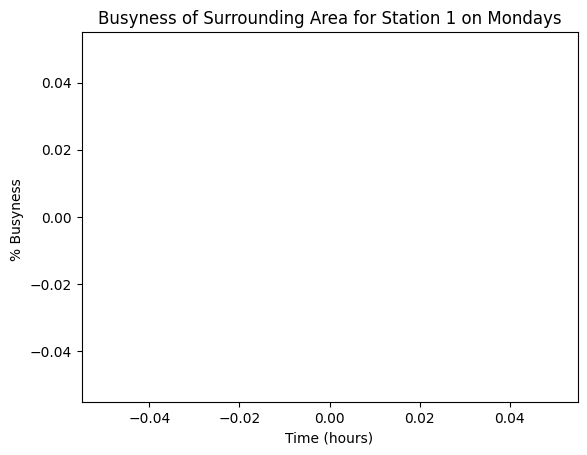

In [28]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays_1['hour'], df_mondays_1['surrounding_area_busyness'])
plt.title("Busyness of Surrounding Area for Station 1 on Mondays")
plt.ylabel("% Busyness ")
plt.xlabel("Time (hours)")
plt.show()


### Description of the models:
- I have made two busyness prediciton models that only need the remote unit id, which can be easily mapped from the lookup table
- Choose surrounding area, or station busyness prediction by selecting the correct folder
- Select the Remote Unit id using the cleaned_station_data.csv file
- The model also requires the following to get the prediciton:
- hour as an int with 0 being midnight, 1 being 1AM etc
- day as an int with 1 being Monday etc
- month as int with 1 being January etc
- temperature as float in Celsius
- rain_fall as float in mm per hour
- snow_fall as float in mm per hour
- Clear as a int, 1 or  0
- Clouds as a int, 1 or  0
- Same for Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow and Thunderstorm

### Plots of some stations over a week

In [29]:
len(df)

297835

In [30]:

def average_station_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['station_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Station Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()


def average_area_busyness(numb):
    # filter the DataFrame to only include data for one station
    df_station = df[df['remote_unit_id'] == numb]

    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day','hour'])['surrounding_area_busyness'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Area Busyness for {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Station Busyness")
    plt.ylim(0, 100)
    plt.show()




In [31]:
# we just need to create a collect csv files for both and put them in here
df_static = pd.read_csv('cleaned_station_data.csv')
df_static.head()

,station_name,lat,lon,remote_unit_id,short_name
0,Lexington Av/59 St,40.762660,-73.967258,16,LEXINGTON-53 ST
1,Lexington Av/59 St,40.762660,-73.967258,17,LEXINGTON-53 ST
2,Lexington Av/59 St,40.762660,-73.967258,50,59 ST
3,Lexington Av/59 St,40.762660,-73.967258,51,59 ST
4,5 Av/59 St,40.764811,-73.973347,79,5 AVE-59 ST


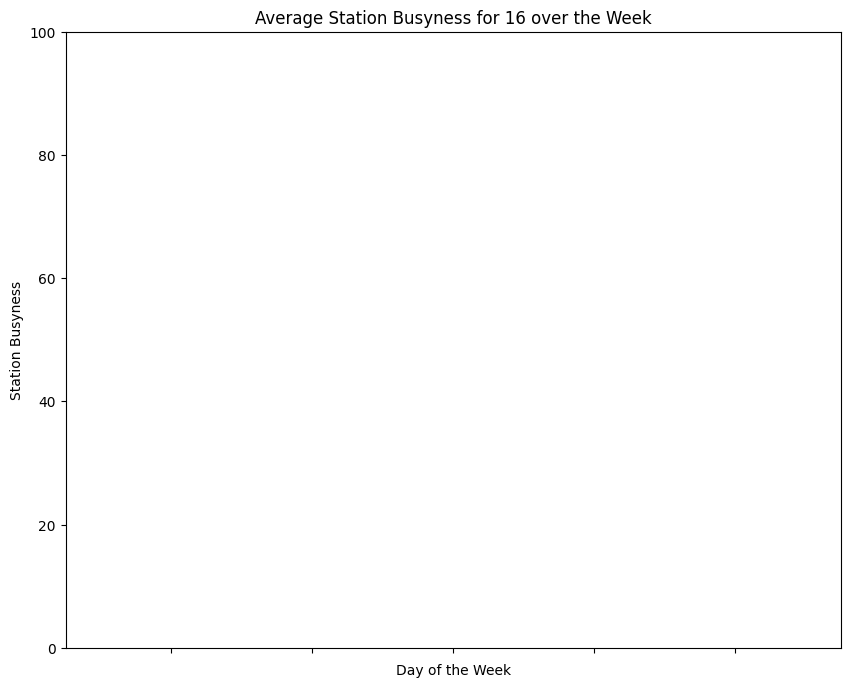

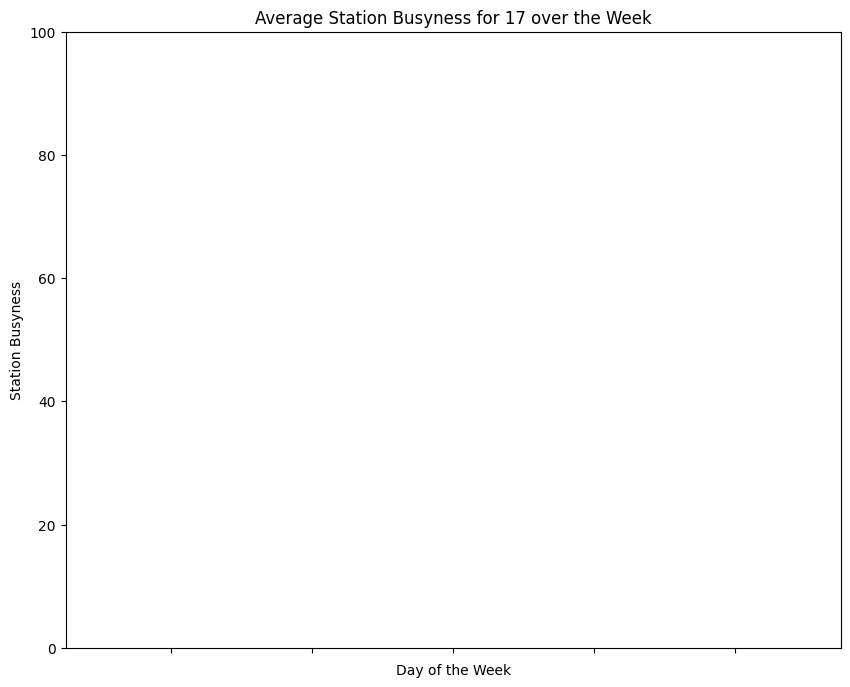

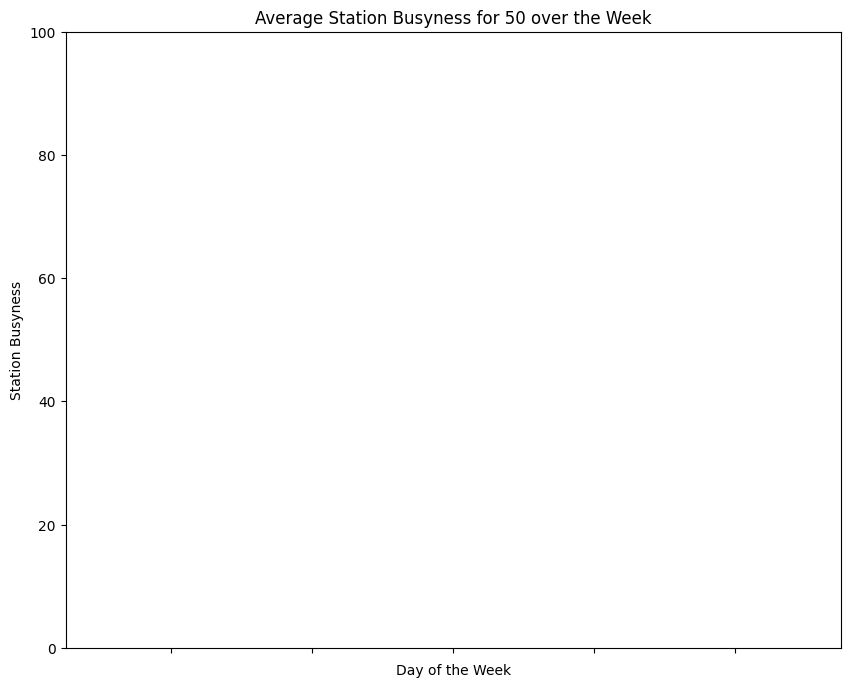

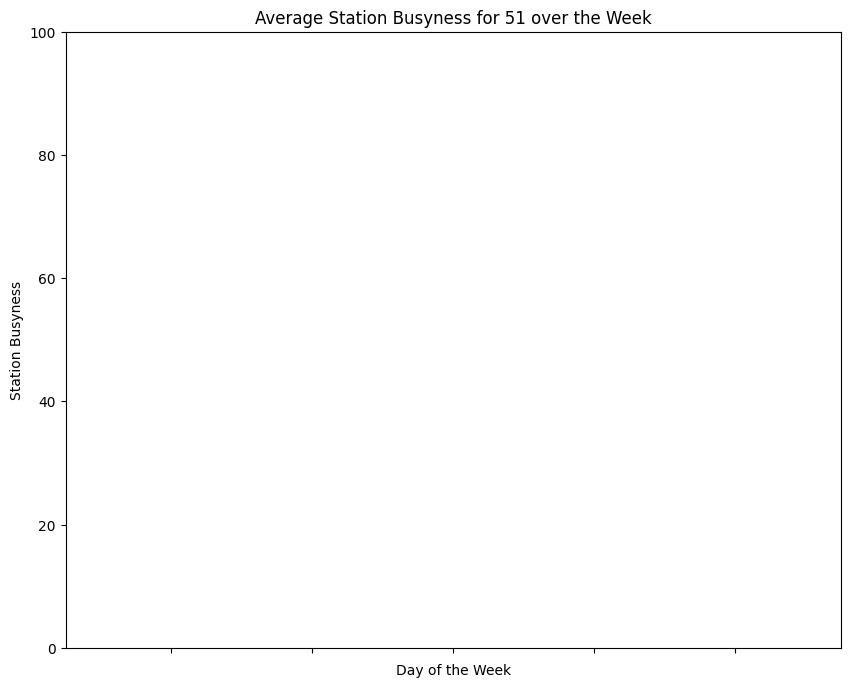

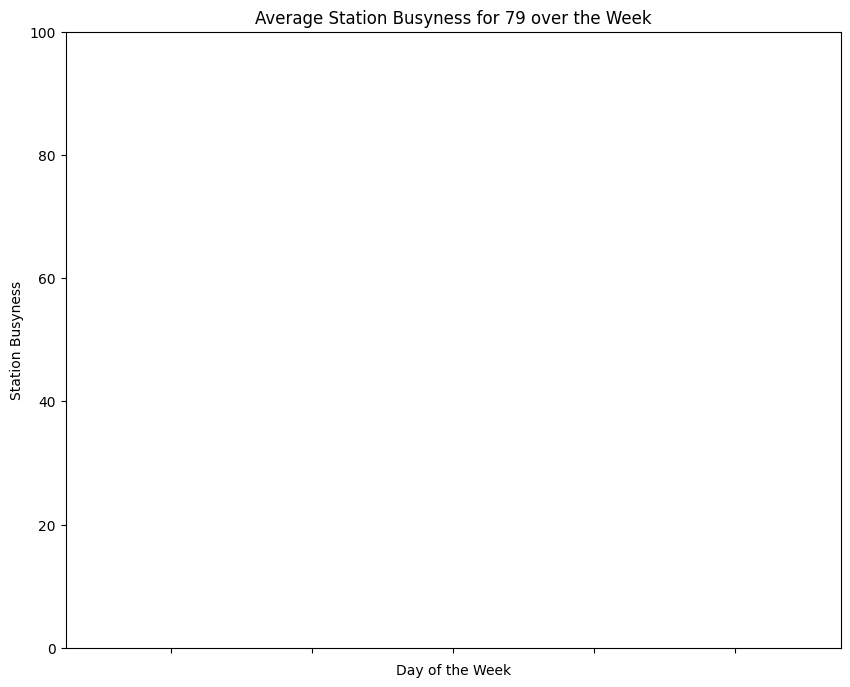

In [32]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_station_busyness(numb)

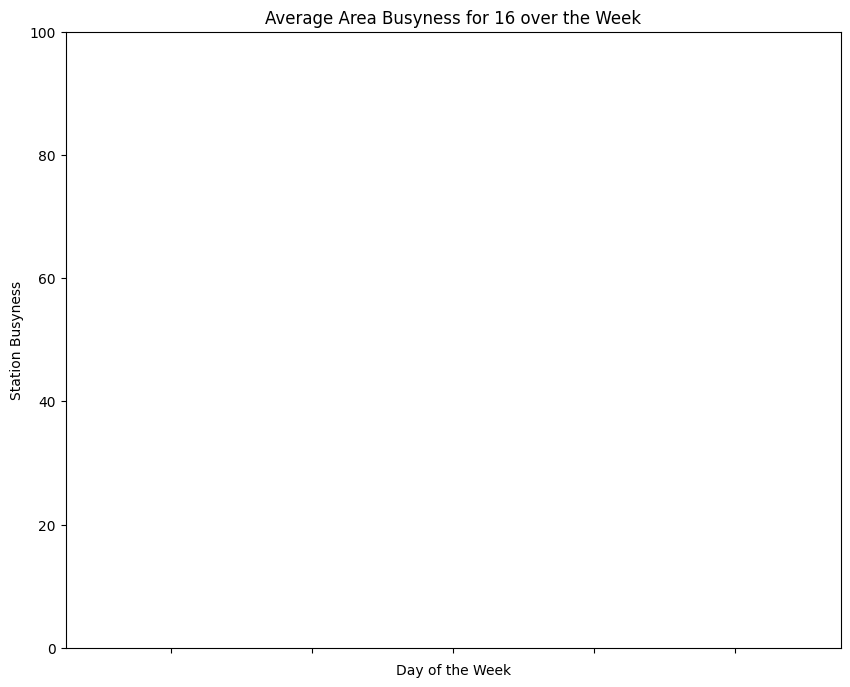

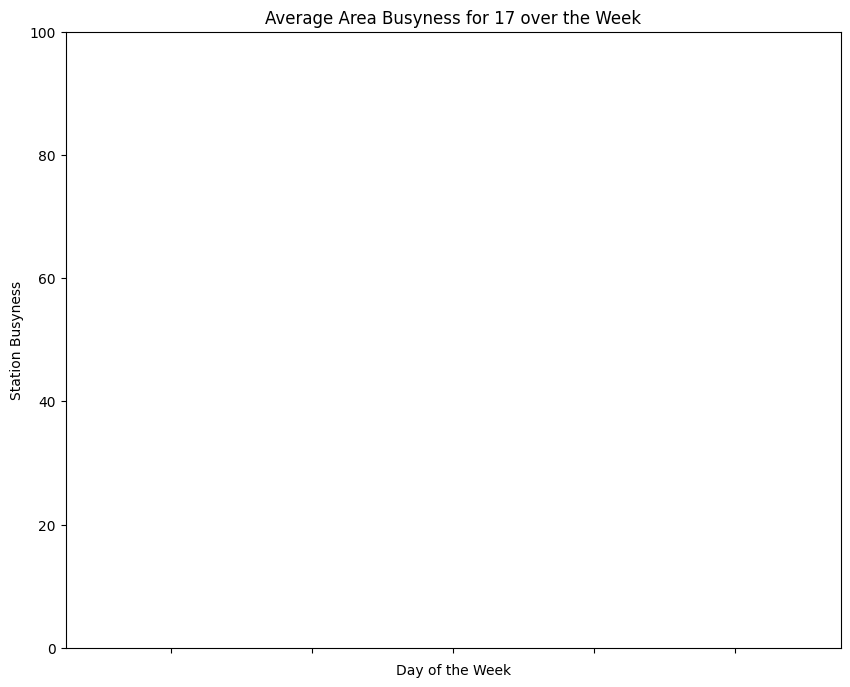

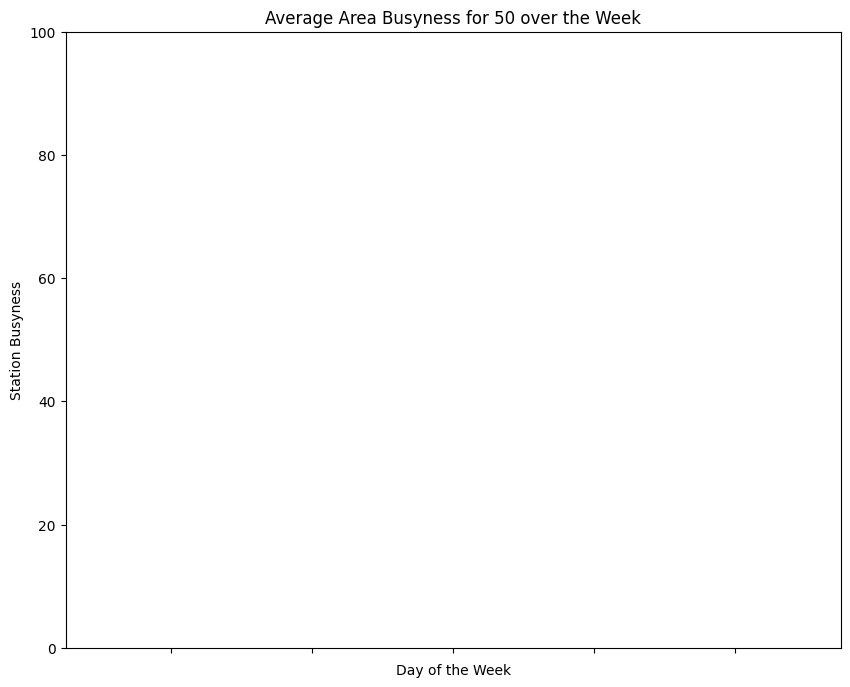

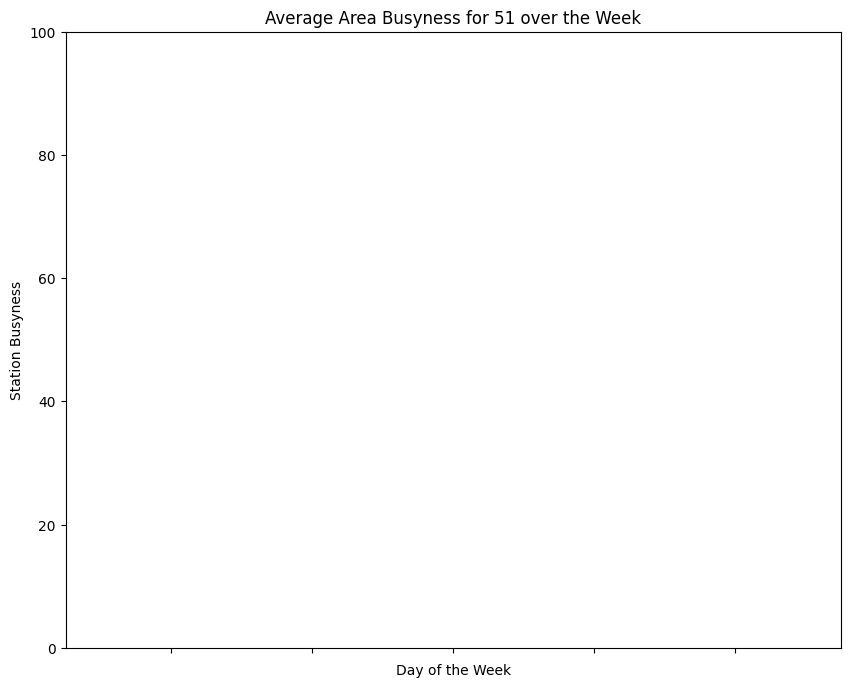

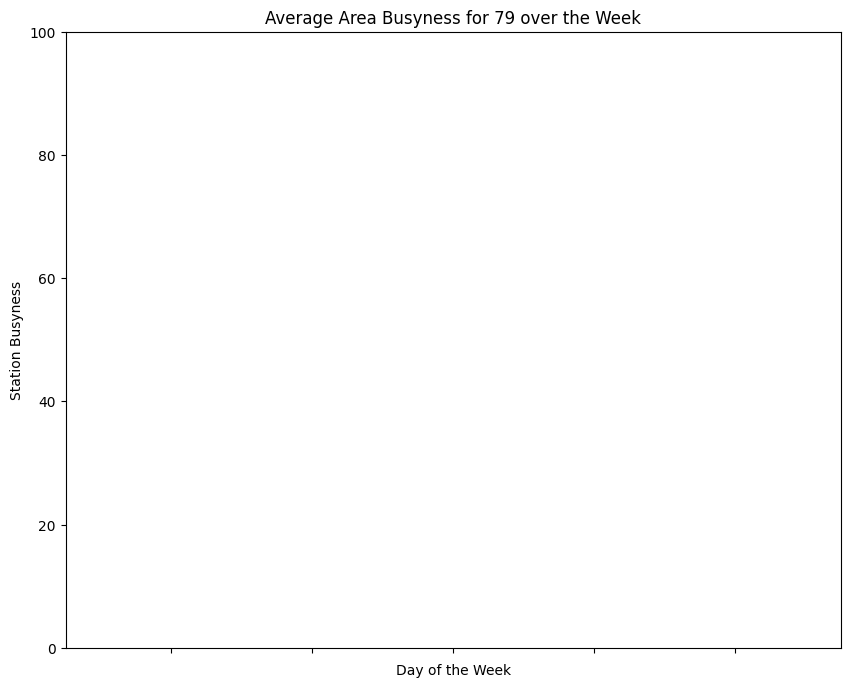

In [33]:
#pick some stations to plot
length = len(df_static['remote_unit_id'])
for i in range(0, 5):
    numb=df_static['remote_unit_id'][i]
    average_area_busyness(numb)